# <font color=#323232>Part 1: Optimizing and Training a CNN Model for Bird Image Classification</font>

### <font color=#333333>1. Import Libraries | Check for Available GPU | Set Dataset Locations</font>
#### <font color=#404040>&emsp;&emsp;1.1 Import the Necessary Libraries</font>
#### <font color=#404040>&emsp;&emsp;1.2 Check for Available GPU</font>
#### <font color=#404040>&emsp;&emsp;1.3 Set Dataset Locations</font>
### <font color=#333333>2. Resize Images | Set Batch Size | Create Train and Validation Datasets</font>
### <font color=#333333>3. Exploration of the Classes we're Working with and the Images of the Dataset</font>
#### <font color=#404040>&emsp;&emsp;3.1 Exploration of the Classes</font>
#### <font color=#404040>&emsp;&emsp;3.2 Some Sample Images from the Dataset</font>
### <font color=#333333>4. CNN Models</font>
#### <font color=#404040>&emsp;&emsp;4.1 Helper Functions</font>
#### <font color=#404040>&emsp;&emsp;4.2 Classification Models</font>
#### <font color=#404040>&emsp;&emsp;&emsp;&emsp;4.2.1 A Basic CNN Model with 4 Convolutional Layers</font>
#### <font color=#404040>&emsp;&emsp;&emsp;&emsp;4.2.2 Addition of Dropout Layers to Reduce Overfitting</font>
#### <font color=#404040>&emsp;&emsp;&emsp;&emsp;4.2.3 Replacing the Flatten Layer with a GlobalMaxPooling2D Layer</font>
#### <font color=#404040>&emsp;&emsp;&emsp;&emsp;4.2.4 Further Improving the Model with L1/L2 Regularization</font>
#### <font color=#404040>&emsp;&emsp;&emsp;&emsp;4.2.5 Adding Residual Connections</font>
### <font color=#333333>5. Final Statistics and Observations</font>

## 1. Import Libraries | Check for Available GPU | Set Dataset Locations

### 1.1 Import the Necessary Libraries

In [9]:
# Importing the necessary libraries
import time
from tabulate import tabulate
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

### 1.2 Check for Available GPU

In [10]:
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 1.3 Set Dataset Locations

The dataset used for this classification task is the "BIRDS 525 SPECIES- IMAGE CLASSIFICATION" dataset from kaggle:

https://www.kaggle.com/datasets/gpiosenka/100-bird-species

This dataset contains 84635 total training images and 2625 validation images (5 per bird species). Ideally the notebook should run on Kaggle and the dataset should already be loaded from the relavant option in the left menu. In order for the notrebook to run locally, the pathing for train_dir and val_dir should be adjusted accordingly.

Note: There is no data augmentation on this dataset and I chose not to apply either as the dataset is already too big and some experiments I made earlier with data augmentation increased the training times significantly.

In [11]:
# location of the training and validation data for the 525 birds dataset
train_dir = "/kaggle/input/100-bird-species/train"
val_dir = "/kaggle/input/100-bird-species/valid"

## 2. Resize Images | Set Batch Size | Create Train and Validation Datasets

The following code resizes the images to 180x180 and sets the batch size to 64.

In [12]:
image_size = (180, 180)
batch_size = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


## 3. Exploration of the Classes we're Working with and the Images of the Dataset

### 3.1 Exploration of the Classes

In [13]:
class_names = train_ds.class_names

print('This dataset contains', len(class_names), 'bird species.')

This dataset contains 525 bird species.


### 3.2 Some Sample Images from the Dataset

A sample of 9 images from the dataset.

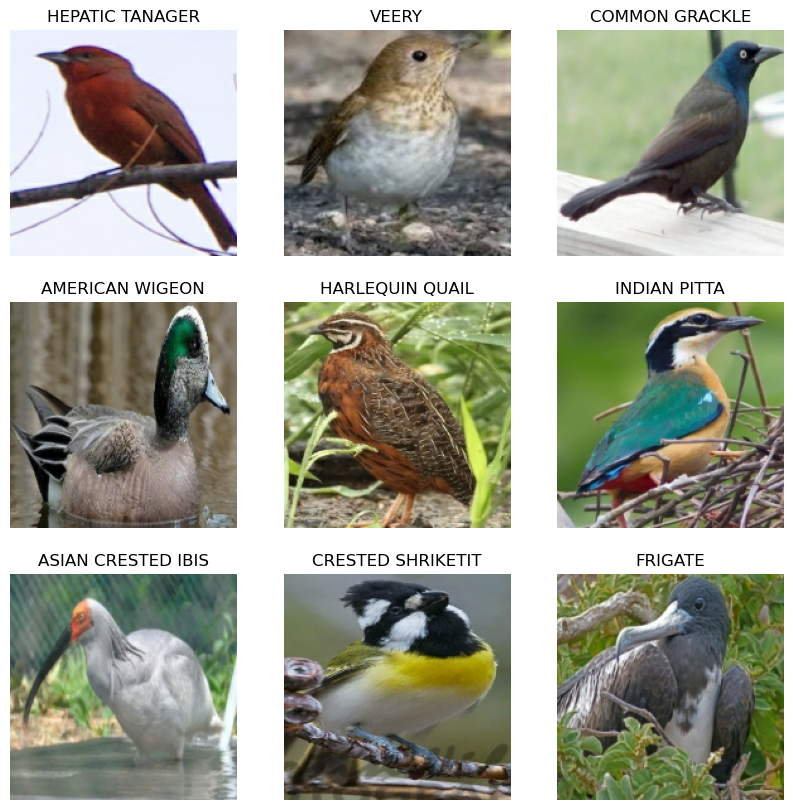

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image = images[i].numpy().astype("uint8")
        label = labels[i].numpy()
        bird_name = class_names[label].replace("-", " ")
        plt.imshow(image)
        plt.title(bird_name)
        plt.axis("off")

## 4. CNN Models

### 4.1 Helper Functions

Before we start training the models we are going to need some function to facilitate this process. Below you can find 4 functions that achieve differeng goals.
The first function diplays some general stats about the model, like the layer structure and the amount of trainable and non-trainable (frozen) parameters.

In [15]:
# A function that displays the model layers and the parameters of each layer as well as the frozen (non-trainable) parameters
def display_model_stats(model):
    print(model.summary())

The next function will be used to display the fluctuations of the training and validation accuracy and loss throughtout the training of the model. After the training of each model the function will output these stats in graph form.

In [16]:
# A function to plot the training and validation accuracy and loss
def plot_model_accuracy_and_loss(metrics):
    acc = metrics.history["accuracy"]
    val_acc = metrics.history["val_accuracy"]
    loss = metrics.history["loss"]
    val_loss = metrics.history["val_loss"]
    epochs = range(1, len(acc) + 1)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot training and validation accuracy
    ax1.plot(epochs, acc, "r", label="Training accuracy")
    ax1.plot(epochs, val_acc, "g", label="Validation accuracy")
    ax1.set_title("Training and Validation accuracy")
    ax1.legend()

    # Plot training and validation loss
    ax2.plot(epochs, loss, "r", label="Training loss")
    ax2.plot(epochs, val_loss, "g", label="Validation loss")
    ax2.set_title("Training and Validation loss")
    ax2.legend()

    # Adjust the spacing between subplots
    fig.tight_layout()

    # Display the figure
    plt.show()

This array will store the statistics of all models trained in order to extract meaningful information after all models have finished training.

In [17]:
# An array that will store all training data for the models like time and epochs to extract general statistics later
global_model_stats = []

The function train_model compiles the model given as an input and then decides which callback function will be used based on the rest of the inputs during the training of the model. There is also a calulation for the time needed to train the model, as well as thw average time needed per epochs which will be particularly useful as some models were trained in a different number of epochs than others.

In [18]:
# A function to compile and fit the model that also returns metrics
def train_model(model, train_dataset, validation_dataset, epochs, early_stopping = False, save_model = False):
    # Compile the Model
    model.compile(loss="sparse_categorical_crossentropy",
             metrics=["accuracy"],
             optimizer="adam")
    
    # Start the timer
    start_time = time.time()
    
    # Check if the model is not improving validation loss and stop early
    # In this case it will always be False to help with visualizations
    if early_stopping == True:
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        metrics = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=[es_callback])
    # Option to save the model
    elif save_model == True:
        checkpoint_filepath = '/kaggle/working/'+ model.name +'.h5'
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
        metrics = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=[model_checkpoint_callback])
    else:
        metrics = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)
        
    # Calculate the model metrics
    end_time = time.time()
    training_time = int(end_time - start_time)
    training_time_per_epoch = round(training_time/epochs, 2)
    highest_train_accuracy = max(metrics.history['accuracy'])
    highest_val_accuracy = max(metrics.history['val_accuracy'])

    # Saving the model's metrics to the array
    global_model_stats.append([model.name, training_time, epochs, training_time_per_epoch, highest_train_accuracy, highest_val_accuracy])
    
    print('-----------------------------------------------------------------------------------')
    print(f'The training of the {model.name} required a total of {training_time} seconds for {epochs} epochs.')
    
    return metrics

### 4.2 Classification Models

#### 4.2.1 A Basic CNN Model with 4 Convolutional Layers

The first model tested is a pretty basic CNN architecture with 4 convolutional layers with progressively increasing number of filters. Every convolutional layer is followed by a MaxPooling2D layer and before the final classification (Dense) layer there is a Flatten layer.

In [19]:
inputs = keras.Input(shape=(180, 180, 3))

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(32, (3, 3), activation="relu")(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(64, (3, 3), activation="relu")(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(128, (3, 3), activation="relu")(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(256, (3, 3), activation="relu")(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Flatten()(x)

outputs = layers.Dense(525, activation="softmax")(x)

model_1 = keras.Model(inputs, outputs, name = 'Basic_CNN_Model')

Using the function we defined earlier we can see the model architecture, as well as the parameters to be trained in each layer.

In [20]:
# Visualization of the model layers
display_model_stats(model_1)

Model: "Basic_CNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                               

In [21]:
# Training of the model
model_1_metrics = train_model(model_1, train_ds, val_ds, 15)

Epoch 1/15
1323/1323 [==============================] - 346s 255ms/step - loss: 4.1199 - accuracy: 0.2337 - val_loss: 2.4768 - val_accuracy: 0.4747
Epoch 2/15
1323/1323 [==============================] - 116s 87ms/step - loss: 1.8876 - accuracy: 0.5873 - val_loss: 2.0055 - val_accuracy: 0.5710
Epoch 3/15
1323/1323 [==============================] - 123s 92ms/step - loss: 0.9491 - accuracy: 0.7790 - val_loss: 2.3275 - val_accuracy: 0.5779
Epoch 4/15
1323/1323 [==============================] - 107s 81ms/step - loss: 0.4415 - accuracy: 0.8897 - val_loss: 3.0679 - val_accuracy: 0.5627
Epoch 5/15
1323/1323 [==============================] - 106s 80ms/step - loss: 0.2292 - accuracy: 0.9371 - val_loss: 4.1579 - val_accuracy: 0.5497
Epoch 6/15
1323/1323 [==============================] - 110s 82ms/step - loss: 0.1621 - accuracy: 0.9523 - val_loss: 4.3646 - val_accuracy: 0.5608
Epoch 7/15
1323/1323 [==============================] - 107s 81ms/step - loss: 0.1277 - accuracy: 0.9625 - val_loss: 

After training the model for 15 epochs we can see that it has clearly overfit the training data as the validation accuracy reaches a plateau after only 2 epochs while the training accuracy continues to increase and gets really close to perfect. The validation loss also increases, another indicator that the model doesn't generalize well.

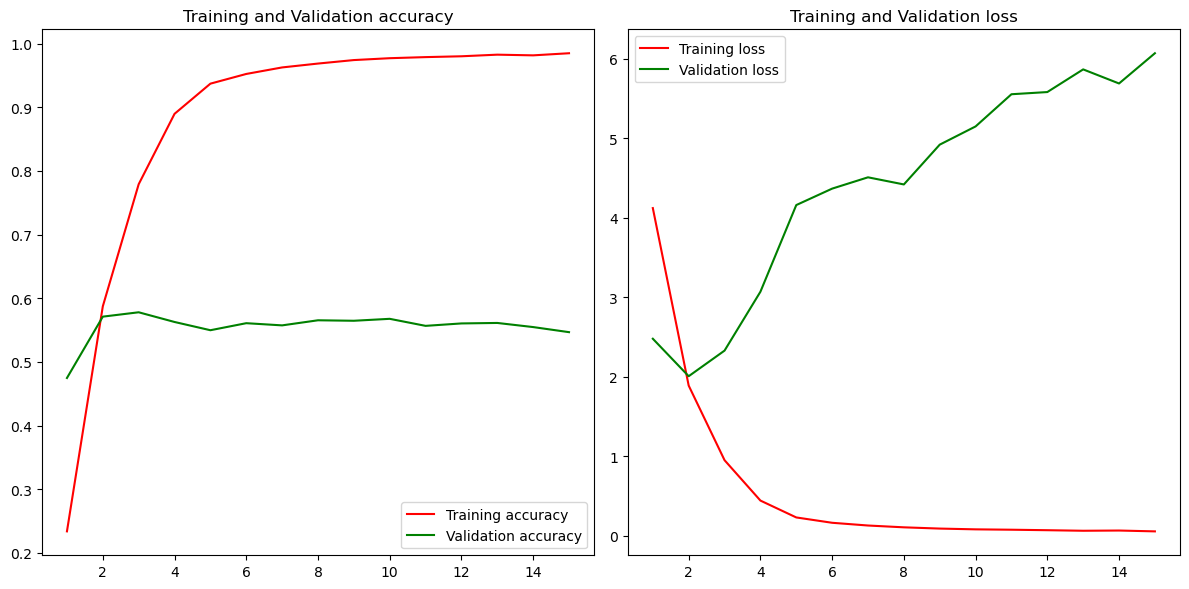

In [22]:
# Display stats
plot_model_accuracy_and_loss(model_1_metrics)

#### 4.2.2 Addition of Dropout Layers to Reduce Overfitting

The first approach to reduce overfitting is to add a Dropout layer after each colvolutional layer.

Dropout layers serve two primary purposes: 
* First, by dropping out neurons, the model becomes less reliant on any single neuron or set of neurons with perceived greater value. This encourages the model to learn more robust and generalizable representations of the data. 
* Second, dropout acts as a form of regularization by introducing noise and reducing co-adaptation between neurons, thereby preventing overfitting and improving the model's ability to generalize to unseen data.

In [23]:
inputs = keras.Input(shape=(180, 180, 3))

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(32, (3, 3), activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(64, (3, 3), activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(128, (3, 3), activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(256, (3, 3), activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Flatten()(x)

outputs = layers.Dense(525, activation="softmax")(x)

model_2 = keras.Model(inputs, outputs, name = 'Model_with_Dropout_Layers')

In [24]:
# Visualization of the model layers
display_model_stats(model_2)

Model: "Model_with_Dropout_Layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 dropout (Dropout)           (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 64)        18496     
                                         

In [25]:
# Training of the model
model_2_metrics = train_model(model_2, train_ds, val_ds, 15)

Epoch 1/15


2023-06-21 09:40:58.576353: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inModel_with_Dropout_Layers/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1323/1323 [==============================] - 118s 87ms/step - loss: 4.1612 - accuracy: 0.2273 - val_loss: 3.6970 - val_accuracy: 0.4648
Epoch 2/15
1323/1323 [==============================] - 118s 89ms/step - loss: 2.0512 - accuracy: 0.5537 - val_loss: 2.7811 - val_accuracy: 0.5512
Epoch 3/15
1323/1323 [==============================] - 131s 98ms/step - loss: 1.2262 - accuracy: 0.7121 - val_loss: 2.2619 - val_accuracy: 0.5802
Epoch 4/15
1323/1323 [==============================] - 114s 86ms/step - loss: 0.7612 - accuracy: 0.8076 - val_loss: 2.0713 - val_accuracy: 0.5600
Epoch 5/15
1323/1323 [==============================] - 122s 92ms/step - loss: 0.5155 - accuracy: 0.8590 - val_loss: 2.0511 - val_accuracy: 0.5608
Epoch 6/15
1323/1323 [==============================] - 115s 87ms/step - loss: 0.3607 - accuracy: 0.8976 - val_loss: 1.9908 - val_accuracy: 0.5737
Epoch 7/15
1323/1323 [==============================] - 116s 87ms/step - loss: 0.2922 - accuracy: 0.9169 - val_loss: 1.9923 - val

The addition of dropout layers managed to reduce the validation loss significantly, though it didn't offer much in terms of accuracy. The training time was also reduced marginally.

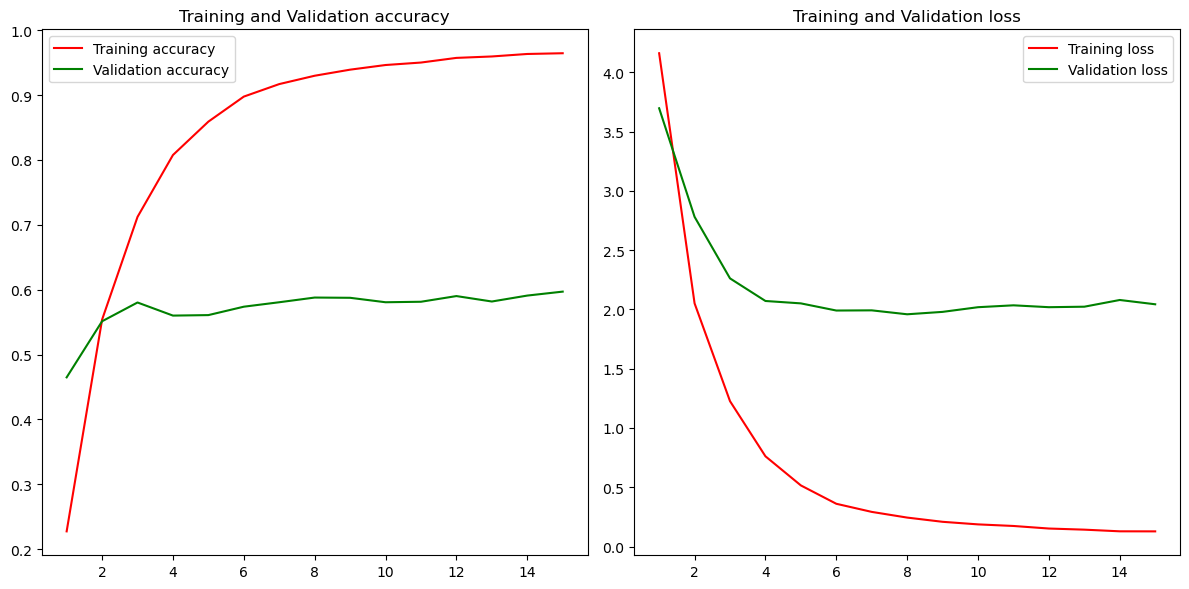

In [26]:
# Display stats
plot_model_accuracy_and_loss(model_2_metrics)

#### 4.2.3 Replacing the Flatten Layer with a GlobalMaxPooling2D Layer

The next step is to replace the Flatten layer before the final Dense layer with a Global Max Pooling 2D layer. Compared to the Flatten layer, which converts the 2D feature maps into a 1D vector, GlobalMaxPooling2D reduces the dimensionality of the feature maps while still preserving the most important spatial information. A major advantage of the GlobalMaxPooling2D layer compared to the Flatten layer is that the former considers the entire feature map, enabling the network to capture global context information. This global perspective is particularly useful for tasks that require a holistic understanding of the input, such as the current classification problem. The addition of the GlobalMaxPooling2D layer will also decrease the number of parameters significantly.

In [27]:
inputs = keras.Input(shape=(180, 180, 3))

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(32, (3, 3), activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(64, (3, 3), activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(128, (3, 3), activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(256, (3, 3), activation="relu")(x)
x = layers.Dropout(0.5)(x)

x = layers.GlobalMaxPooling2D()(x)

outputs = layers.Dense(525, activation="softmax")(x)

model_3 = keras.Model(inputs, outputs, name='Model_with_GlobalMaxPooling2D_Layer')

In [28]:
# Visualization of the model layers
display_model_stats(model_3)

Model: "Model_with_GlobalMaxPooling2D_Layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 dropout_4 (Dropout)         (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 87, 87, 64)        18496     
                               

In [55]:
# Training of the model
model_3_metrics = train_model(model_3, train_ds, val_ds, 15)

Epoch 1/15


2023-06-21 10:26:44.271551: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inModel_with_GlobalMaxPooling2D_Layer/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1323/1323 [==============================] - 137s 101ms/step - loss: 2.6063 - accuracy: 0.4410 - val_loss: 3.5065 - val_accuracy: 0.5299
Epoch 2/15
1323/1323 [==============================] - 116s 87ms/step - loss: 2.2716 - accuracy: 0.5028 - val_loss: 3.2137 - val_accuracy: 0.5832
Epoch 3/15
1323/1323 [==============================] - 115s 86ms/step - loss: 2.0415 - accuracy: 0.5465 - val_loss: 3.0688 - val_accuracy: 0.5992
Epoch 4/15
1323/1323 [==============================] - 115s 86ms/step - loss: 1.8772 - accuracy: 0.5783 - val_loss: 2.8807 - val_accuracy: 0.6179
Epoch 5/15
1323/1323 [==============================] - 114s 86ms/step - loss: 1.7496 - accuracy: 0.6021 - val_loss: 2.7850 - val_accuracy: 0.6343
Epoch 6/15
1323/1323 [==============================] - 114s 86ms/step - loss: 1.6498 - accuracy: 0.6207 - val_loss: 2.6633 - val_accuracy: 0.6636
Epoch 7/15
1323/1323 [==============================] - 115s 86ms/step - loss: 1.5683 - accuracy: 0.6376 - val_loss: 2.5931 - va

The addition of the GlobalMaxPooling2D layer drastically improved the validation accuracy, while at the same time reducing the training accuracy, which show that our model no loger overfits the data. As a matter of fact it seems like the validation accuracy would continue to improve if the model was trained for more epochs.

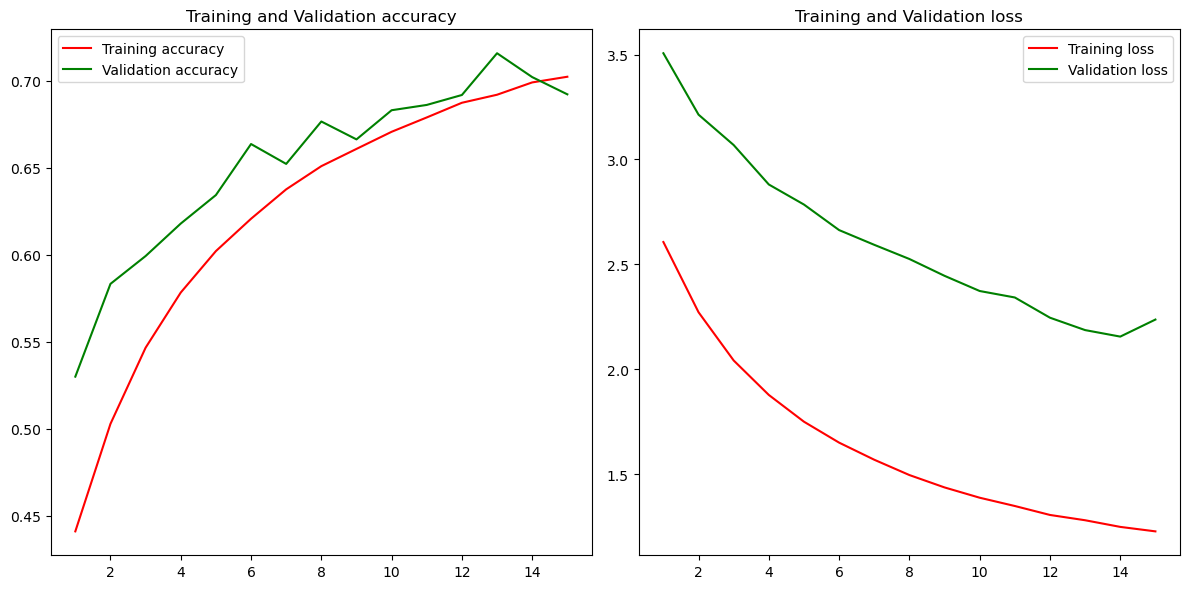

In [56]:
# Display stats
plot_model_accuracy_and_loss(model_3_metrics)

#### 4.2.4 Further Improving the Model with L1/L2 Regularization

In the final model, L1/L2 regularization is inserted in the first 2 convolutional layers. Through the penalties applied to the loss function this approach manages to keep the overall weights lower. Specifically, L1 regularization promotes sparsity and feature selection, while L2 regularization encourages overall weight reduction.
So, the L1/L2 regularization is expected to further reduce overfitting and improve the model's ability to generalize.

In [63]:
inputs = keras.Input(shape=(180, 180, 3))

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(32, (3, 3), activation="relu", kernel_regularizer=keras.regularizers.L1L2())(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(64, (3, 3), activation="relu", kernel_regularizer=keras.regularizers.L1L2())(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(128, (3, 3), activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(256, (3, 3), activation="relu")(x)
x = layers.Dropout(0.5)(x)

x = layers.GlobalMaxPooling2D()(x)

outputs = layers.Dense(525, activation="softmax")(x)

model_4 = keras.Model(inputs, outputs, name = 'Model_with_L1L2_Regularization')

In [64]:
# Visualization of the model layers
display_model_stats(model_4)

Model: "Model_with_L1L2_Regularization"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_116 (Conv2D)         (None, 178, 178, 32)      896       
                                                                 
 dropout_91 (Dropout)        (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_117 (Conv2D)         (None, 87, 87, 64)        18496     
                                    

In [65]:
# Training of the model
model_4_metrics = train_model(model_4, train_ds, val_ds, 50, save_model = True)

Epoch 1/50


2023-06-21 11:19:32.791598: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inModel_with_L1L2_Regularization/dropout_91/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1323/1323 [==============================] - 122s 90ms/step - loss: 4.9848 - accuracy: 0.0880 - val_loss: 4.6687 - val_accuracy: 0.2526
Epoch 2/50
1323/1323 [==============================] - 116s 87ms/step - loss: 3.3386 - accuracy: 0.3091 - val_loss: 3.9464 - val_accuracy: 0.4381
Epoch 3/50
1323/1323 [==============================] - 115s 87ms/step - loss: 2.6355 - accuracy: 0.4349 - val_loss: 3.5169 - val_accuracy: 0.5181
Epoch 4/50
1323/1323 [==============================] - 117s 88ms/step - loss: 2.2614 - accuracy: 0.5051 - val_loss: 3.3573 - val_accuracy: 0.5368
Epoch 5/50
1323/1323 [==============================] - 117s 88ms/step - loss: 2.0316 - accuracy: 0.5481 - val_loss: 3.0868 - val_accuracy: 0.5775
Epoch 6/50
1323/1323 [==============================] - 119s 89ms/step - loss: 1.8723 - accuracy: 0.5788 - val_loss: 3.0060 - val_accuracy: 0.5851
Epoch 7/50
1323/1323 [==============================] - 121s 91ms/step - loss: 1.7483 - accuracy: 0.6011 - val_loss: 2.9240 - val

After training this model for 50 epochs we can see that the validation accuracy was marginally improved (from 71% to 74%) compared to the previous best model. Given the large number of classes this improvement might seem small but it is actually significant.

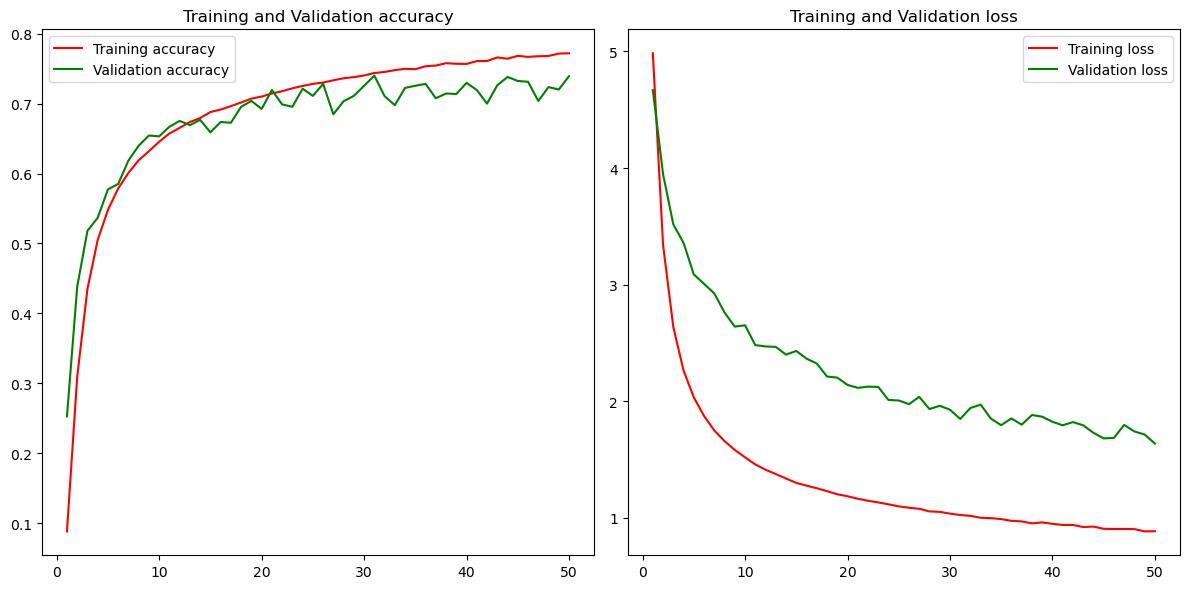

In [66]:
# Display stats
plot_model_accuracy_and_loss(model_4_metrics)

#### 4.2.5 Adding Residual Connections

The final step is to add residual connections to the model. After the two first convolutional layers, this network contains 6 more blocks of convolutional layers with residual connections. Every block contains two convolutional layers followed by a BatchNormalization layer and a Dropout layer. We are also removing the dropout from the first two convolutional layers in this model and instead adding it only to the 6 blocks. The 6 blocks of residual connections are followed by a GlobalMaxPooling2D layer, a Dropout layer and the final classification layer.

In [71]:
# A function to create the residual blocks
def residual_block(x, filters, stride=1, dropout_rate=0.2):
    identity = x

    # First convolutional layer
    x = layers.Conv2D(filters, (3,3), strides=stride, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Second convolutional layer
    x = layers.Conv2D(filters, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Residual connection
    if stride > 1:
        identity = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', )(identity)
    x = layers.Add()([x, identity])
    x = layers.ReLU()(x)

    return x

In [72]:
input_shape = (180, 180, 3)
num_classes = 525

# Create the Model with Residual Connections
inputs = tf.keras.Input(shape=input_shape)

# Initial convolutional layers
x = layers.Conv2D(32, (3, 3), activation="relu", kernel_regularizer=keras.regularizers.L1L2())(inputs)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(64, (3, 3), activation="relu", kernel_regularizer=keras.regularizers.L1L2())(x)
x = layers.MaxPooling2D(2, 2)(x)

# Residual blocks
x = residual_block(x, filters=64)

x = residual_block(x, filters=128, stride=2)
x = residual_block(x, filters=128)

x = residual_block(x, filters=256, stride=2)
x = residual_block(x, filters=256)

x = residual_block(x, filters=512, stride=2)

# Final layers
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_with_residual = tf.keras.Model(inputs, outputs, name = 'Model_with_Residual_Connections')

In [73]:
# Visualization of the model layers
display_model_stats(model_with_residual)

Model: "Model_with_Residual_Connections"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_137 (Conv2D)            (None, 178, 178, 32  896         ['input_21[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_38 (MaxPooling2D  (None, 89, 89, 32)  0           ['conv2d_137[0][0]']             
 )                                                                  

In [74]:
# Training of the model
model_with_residual_stats = train_model(model_with_residual, train_ds, val_ds, 50, save_model=True)

Epoch 1/50


2023-06-21 13:53:08.337145: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inModel_with_Residual_Connections/dropout_110/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1323/1323 [==============================] - 158s 103ms/step - loss: 6.1936 - accuracy: 0.0061 - val_loss: 5.7944 - val_accuracy: 0.0179
Epoch 2/50
1323/1323 [==============================] - 135s 102ms/step - loss: 5.5709 - accuracy: 0.0243 - val_loss: 5.0702 - val_accuracy: 0.0606
Epoch 3/50
1323/1323 [==============================] - 135s 101ms/step - loss: 4.9448 - accuracy: 0.0634 - val_loss: 4.1368 - val_accuracy: 0.1672
Epoch 4/50
1323/1323 [==============================] - 137s 103ms/step - loss: 4.4104 - accuracy: 0.1179 - val_loss: 3.4576 - val_accuracy: 0.2796
Epoch 5/50
1323/1323 [==============================] - 136s 102ms/step - loss: 3.9107 - accuracy: 0.1871 - val_loss: 2.7861 - val_accuracy: 0.4034
Epoch 6/50
1323/1323 [==============================] - 138s 104ms/step - loss: 3.4584 - accuracy: 0.2571 - val_loss: 2.3255 - val_accuracy: 0.5048
Epoch 7/50
1323/1323 [==============================] - 138s 104ms/step - loss: 3.0761 - accuracy: 0.3244 - val_loss: 2.159

As we can see the addition of residual blocks increased the accuracy of the model significantly but also increased the training time as the model parameters also increased by a lot. Specifically, the validation accuracy improved by around 12% compared to the previous best model (from 74% to 86%) and it would probably reach an even higher number if the training was longer than 50 epochs.

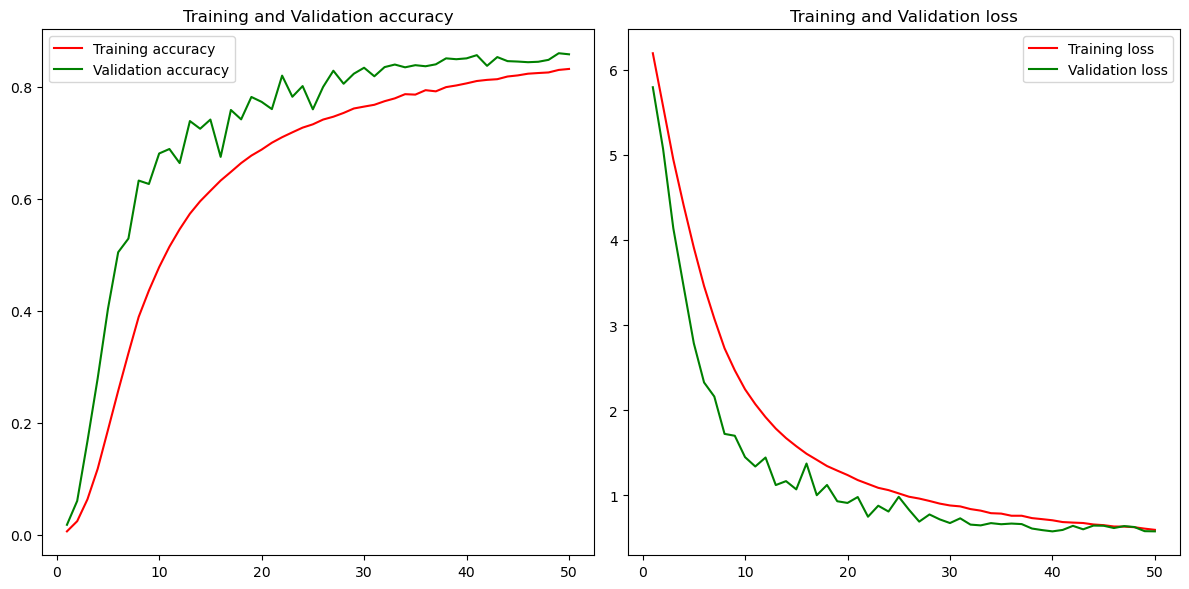

In [75]:
# Display stats
plot_model_accuracy_and_loss(model_with_residual_stats)

### 5. Final Statistics and Obesrvations

The following table shows that the earlier models with flatten layer and without dropout tend to overfit alot and learn the training data too well. Both the addition of Dropout layers and the replacement of the Flatten layer with a GlobalMaxPooling 2D layer was enough to stop the model from overfitting and improve the validation accuracy. The L1/L2 regularization also improved the accuracy while keeping the training times relatively low. Finally, the addition of residual blocks improved the accuracy by a lot but it also increased the training time as we are now training more parameters.

In [77]:
print(tabulate(global_model_stats, headers=['Model Name', 'Training Time', 'Number of Epochs', 'Training Time per Epoch', 'Training Accuracy', 'Validation Accuracy'], tablefmt="fancy_grid"))

╒═════════════════════════════════════╤═════════════════╤════════════════════╤═══════════════════════════╤═════════════════════╤═══════════════════════╕
│ Model Name                          │   Training Time │   Number of Epochs │   Training Time per Epoch │   Training Accuracy │   Validation Accuracy │
╞═════════════════════════════════════╪═════════════════╪════════════════════╪═══════════════════════════╪═════════════════════╪═══════════════════════╡
│ Basic_CNN_Model                     │            2050 │                 15 │                    136.67 │            0.984841 │              0.577905 │
├─────────────────────────────────────┼─────────────────┼────────────────────┼───────────────────────────┼─────────────────────┼───────────────────────┤
│ Model_with_Dropout_Layers           │            1856 │                 15 │                    123.73 │            0.964471 │              0.596952 │
├─────────────────────────────────────┼─────────────────┼────────────────────┼────